tb - Train coefficients of a simple analytic model for SW radiative transfer via stochastic gradient descent

Then calculate (1) Number of free parameters; and (2) error statistics of the net shortwave flux prediction (in $W m^{-2}$)

# Imports

In [1]:
from ml4rt.io.example_io import *
from ml4rt.utils.normalization import *
from ml4rt.machine_learning.neural_net import *
from ml4rt.machine_learning.u_net_architecture import *
from ml4rt.machine_learning.u_net_pp_architecture import *

import dill

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import tensorflow as tf
from tensorflow import keras as K

In [2]:
fz = 15
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

# Data Generator

### Loading model's metadata using dill

In [3]:
path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/'

In [4]:
model_arc = dill.load(open(path_data+'actual_model/model_metadata.dill','rb'))

In [5]:
model_arc.keys()

dict_keys(['num_epochs', 'num_training_batches_per_epoch', 'training_option_dict', 'num_validation_batches_per_epoch', 'validation_option_dict', 'net_type_string', 'loss_function_or_dict', 'do_early_stopping', 'plateau_lr_multiplier'])

In [6]:
model_arc['net_type_string']

'u_net'

In [7]:
model_arc['validation_option_dict']

{'scalar_predictor_names': ['zenith_angle_radians', 'albedo'],
 'vector_predictor_names': ['pressure_pascals',
  'temperature_kelvins',
  'specific_humidity_kg_kg01',
  'liquid_water_content_kg_m03',
  'ice_water_content_kg_m03',
  'relative_humidity_unitless',
  'liquid_water_path_kg_m02',
  'ice_water_path_kg_m02',
  'vapour_path_kg_m02',
  'upward_liquid_water_path_kg_m02',
  'upward_ice_water_path_kg_m02',
  'upward_vapour_path_kg_m02'],
 'scalar_target_names': ['shortwave_surface_down_flux_w_m02',
  'shortwave_toa_up_flux_w_m02'],
 'vector_target_names': ['shortwave_heating_rate_k_day01'],
 'heights_m_agl': array([1.00e+01, 2.00e+01, 4.00e+01, 6.00e+01, 8.00e+01, 1.00e+02,
        1.20e+02, 1.40e+02, 1.60e+02, 1.80e+02, 2.00e+02, 2.25e+02,
        2.50e+02, 2.75e+02, 3.00e+02, 3.50e+02, 4.00e+02, 4.50e+02,
        5.00e+02, 6.00e+02, 7.00e+02, 8.00e+02, 9.00e+02, 1.00e+03,
        1.10e+03, 1.20e+03, 1.30e+03, 1.40e+03, 1.50e+03, 1.60e+03,
        1.70e+03, 1.80e+03, 1.90e+03, 2.0

In [8]:
model_arc['validation_option_dict']['example_dir_name'] = \
'/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites'

In [9]:
model_arc['validation_option_dict']['normalization_file_name'] = model_arc['validation_option_dict']['example_dir_name'] + \
'/learning_examples_20170101-20181224.nc'

In [10]:
model_arc['validation_option_dict']['first_time_unix_sec'] = 1514764800 # Jan 1, 2018 at 12:00:00AM
model_arc['validation_option_dict']['last_time_unix_sec'] = 1546300799 # Dec 31, 2018 at 11:59:59PM

In [11]:
Unetpp_gen = data_generator(model_arc['validation_option_dict'],True,model_arc['net_type_string'])

In [12]:
Unetpp_data = create_data(model_arc['validation_option_dict'],True, 
                          model_arc['net_type_string'],exclude_summit_greenland=True)

Reading training examples (for normalization) from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_20170101-20181224.nc"...

Reading data from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_2018.nc"...


/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/ml4rt/notebooks_tbeucler/ml4rt/io/example_io.py:304: UserWarning: Removing 0 of 898025 examples (profiles), because they are at Summit GL.
  warnings.warn(warning_string)


Applying Z_SCORE normalization to predictors...
Applying MINMAX normalization to scalar targets...


# Create small prototype using xarray

## Data loading and pre-processing

In [13]:
data2018 = xr.open_dataset('/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_2018.nc')

In [14]:
data2018['vector_target_names']

<xarray.DataArray 'vector_target_names' (vector_target: 5)>
array([b'shortwave_down_flux_w_m02', b'shortwave_up_flux_w_m02',
       b'shortwave_heating_rate_k_day01',
       b'shortwave_down_flux_increment_w_m03',
       b'shortwave_up_flux_increment_w_m03'], dtype='|S35')
Dimensions without coordinates: vector_target

In [15]:
data2018['scalar_target_names']

<xarray.DataArray 'scalar_target_names' (scalar_target: 2)>
array([b'shortwave_surface_down_flux_w_m02', b'shortwave_toa_up_flux_w_m02'],
      dtype='|S35')
Dimensions without coordinates: scalar_target

In [16]:
data2018['scalar_predictor_names']

<xarray.DataArray 'scalar_predictor_names' (scalar_predictor: 6)>
array([b'zenith_angle_radians', b'albedo', b'latitude_deg_n',
       b'longitude_deg_e', b'column_liquid_water_path_kg_m02',
       b'column_ice_water_path_kg_m02'], dtype='|S35')
Dimensions without coordinates: scalar_predictor

In [17]:
data2018['vector_predictor_names']

<xarray.DataArray 'vector_predictor_names' (vector_predictor: 12)>
array([b'pressure_pascals', b'temperature_kelvins',
       b'specific_humidity_kg_kg01', b'liquid_water_content_kg_m03',
       b'ice_water_content_kg_m03', b'liquid_water_path_kg_m02',
       b'ice_water_path_kg_m02', b'vapour_path_kg_m02',
       b'upward_liquid_water_path_kg_m02', b'upward_ice_water_path_kg_m02',
       b'upward_vapour_path_kg_m02', b'relative_humidity_unitless'],
      dtype='|S35')
Dimensions without coordinates: vector_predictor

In [18]:
data2018['vector_predictor_matrix'].shape

(898025, 73, 12)

In [19]:
pload = data2018['vector_predictor_matrix'][:,:,0].values
pmean = np.mean(pload,axis=0)

In [20]:
data2018['scalar_target_matrix'].shape

(898025, 2)

Text(0.5, 0, 'TOA SW upwards flux (W/m2)')

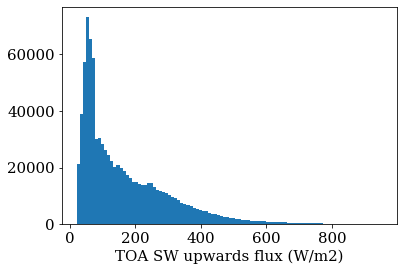

In [21]:
plt.hist(data2018['scalar_target_matrix'][:,1].values.flatten(),bins=100);
plt.xlabel('TOA SW upwards flux (W/m2)')

In [22]:
data2018['vector_target_matrix'].shape

(898025, 73, 5)

Text(0.5, 0, 'TOA SW downwards flux (W/m2)')

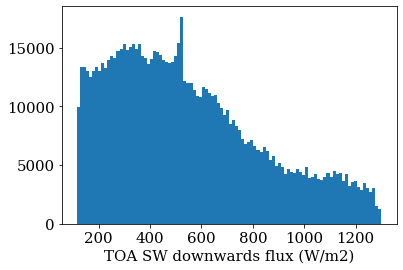

In [23]:
plt.hist(data2018['vector_target_matrix'][:,-1,0].values.flatten(),bins=100);
plt.xlabel('TOA SW downwards flux (W/m2)')

In [24]:
FSWnet_downwards = (data2018['vector_target_matrix'][:,:,0]-data2018['vector_target_matrix'][:,:,1]).values

In [25]:
FSWnet_downwards.shape

(898025, 73)

In [26]:
FSWnet_down_mean = np.mean(FSWnet_downwards,axis=0)
FSWnet_25 = np.percentile(a=FSWnet_downwards,q=25,axis=0)
FSWnet_75 = np.percentile(a=FSWnet_downwards,q=75,axis=0)
FSWnet_1 = np.percentile(a=FSWnet_downwards,q=1,axis=0)
FSWnet_99 = np.percentile(a=FSWnet_downwards,q=99,axis=0)

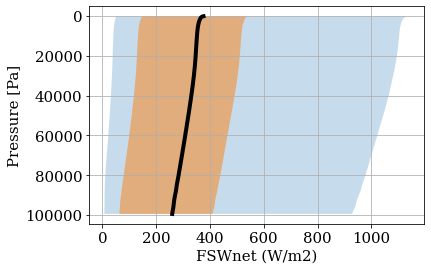

In [27]:
plt.plot(FSWnet_down_mean,pmean,color='k')
plt.fill_betweenx(y=pmean,x1=FSWnet_1,x2=FSWnet_99,alpha=0.25)
plt.fill_betweenx(y=pmean,x1=FSWnet_25,x2=FSWnet_75,alpha=0.5)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('FSWnet (W/m2)');
plt.ylabel('Pressure [Pa]');

Text(0.5, 0, 'Fnet/(Fnet at TOA)')

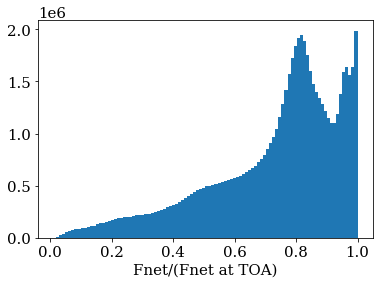

In [28]:
plt.hist((FSWnet_downwards/np.expand_dims(FSWnet_downwards[:,-1],axis=1)).flatten(),bins=100);
plt.xlabel('Fnet/(Fnet at TOA)')

x = [Fnet_top,zenith_angle,p,qv,ql,qi] of length 294  
y = [Fnet] of length 72

In [29]:
zen_angle = data2018['scalar_predictor_matrix'][:,0].values

Text(0.5, 0, 'Zenith Angle (rad)')

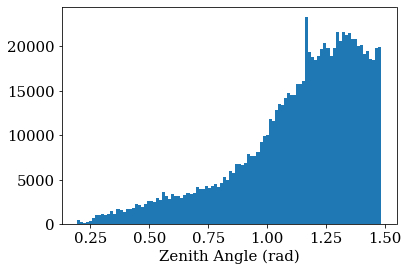

In [30]:
plt.hist(zen_angle.flatten(),bins=100)
plt.xlabel('Zenith Angle (rad)')

In [31]:
pload.shape

(898025, 73)

In [32]:
qvload = data2018['vector_predictor_matrix'][:,:,2].values
qlload = data2018['vector_predictor_matrix'][:,:,3].values
qiload = data2018['vector_predictor_matrix'][:,:,4].values

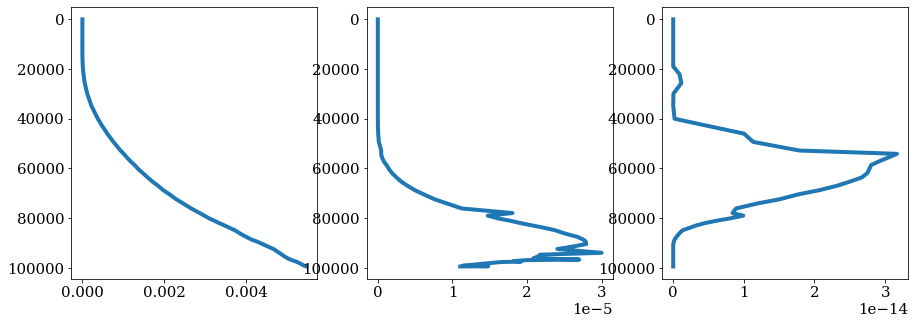

In [33]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].plot(np.mean(qvload,axis=0),pmean)
ax[0].invert_yaxis()

ax[1].plot(np.mean(qlload,axis=0),pmean)
ax[1].invert_yaxis()

ax[2].plot(np.mean(qiload,axis=0),pmean)
ax[2].invert_yaxis()

(0.0, 100.0)

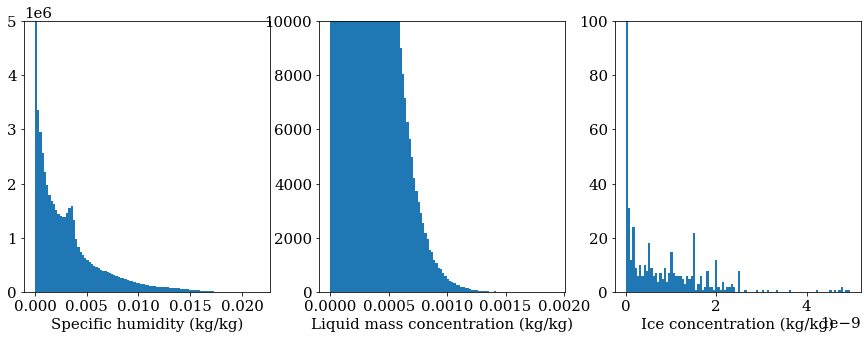

In [34]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].hist(qvload.flatten(),bins=100)
ax[0].set_xlabel('Specific humidity (kg/kg)')
ax[0].set_ylim((0,5e6))

ax[1].hist(qlload.flatten(),bins=100)
ax[1].set_xlabel('Liquid mass concentration (kg/kg)')
ax[1].set_ylim((0,1e4))

ax[2].hist(qiload.flatten(),bins=100)
ax[2].set_xlabel('Ice concentration (kg/kg)')
ax[2].set_ylim((0,1e2))

x = [Fnet_top,zenith_angle,p,qv,ql,qi] of length 294  
y = [Fnet] of length 72

In [35]:
x = np.concatenate((
    np.expand_dims(FSWnet_downwards[:,-1],axis=1),
    np.expand_dims(zen_angle,axis=1),
    pload,
    qvload,
    qlload,
    qiload),
    axis=1
)

In [36]:
x.shape

(898025, 294)

In [37]:
y = FSWnet_downwards[:,]

In [38]:
y.shape

(898025, 73)

## Create custom keras/tf model

In [115]:
class Absorb_Layer(tf.keras.layers.Layer):
    """y = sum(w.q) + b"""

    def __init__(self, input_dim=73, fac_qv=1e3, fac_ql=1e6, fac_qi=1e6, **kwargs):
        super(Absorb_Layer, self).__init__()
        # Assign attributes
        self.input_dim, self.fac_qv, self.fac_ql, self.fac_qi = \
        np.array(input_dim), np.array(fac_qv), np.array(fac_ql), np.array(fac_qi)
        # Random weights initialization and definition for absorption
        k_init = tf.zeros_initializer()
        self.k = tf.Variable(
            initial_value=k_init(shape=(3,), dtype="float32"),
            trainable=True,
            constraint=lambda z: tf.clip_by_value(z, 0, np.infty),
            name='k'
        )
        k0_init = tf.zeros_initializer()
        self.k0 = tf.Variable(
            initial_value=k0_init(shape=(1,), dtype="float32"), trainable=True,
            constraint=lambda z: tf.clip_by_value(z, 0, np.infty),
            name='k0'
        )
        # Hardcode indices for now
        self.QV_i = slice(75,148)
        self.QL_i = slice(148,221)
        self.QI_i = slice(221,294)
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        super().build(input_shape)
    
    def get_config(self):
        config = {'input_dim': self.input_dim, 
                  'fac_qv': self.fac_qv,
                  'fac_ql': self.fac_ql, 
                  'fac_qi': self.fac_qi}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        
        inp = arrs[0]
        
        # 1. Extract QV/QL/QI separately
        qv = inp[:,self.QV_i]
        ql = inp[:,self.QL_i]
        qi = inp[:,self.QI_i]

        # 2. Multiply each one by individual weight and sum it all
        absorb = self.k[0]*self.fac_qv*qv + self.k[1]*self.fac_ql*ql + \
        self.k[2]*self.fac_qi*qi + self.k0 
        
        return absorb

    def compute_output_shape(self, input_shape):
        "It's a simple sum at each level so shape 73"
        return (input_shape[0][0], 73)

In [116]:
class Optical_Thickness(tf.keras.layers.Layer):
    """y = sum(w.q) + b"""

    def __init__(self, input_dim=73, epsilon=1e-2, **kwargs):
        super(Optical_Thickness, self).__init__()
        # Assign attributes
        self.input_dim, self.epsilon = \
        np.array(input_dim), np.array(np.float32(epsilon))
        # Random weights initialization and definition for pressure broadening
#         pbp_init = tf.zeros_initializer()
#         self.pbp = tf.Variable(
#             initial_value=pbp_init(shape=(1,), dtype="float32"),
#             trainable=True,
#             constraint=lambda z: tf.clip_by_value(z, 0, np.infty),
#             name='pbp'
#         )
#         k1_init = tf.zeros_initializer()
#         self.k1 = tf.Variable(
#             initial_value=k1_init(shape=(1,), dtype="float32"), trainable=True,
#             constraint=lambda z: tf.clip_by_value(z, 0, np.infty),
#             name='k1'
#         )
        
        # Hardcode indices for now
        self.zen_ang_i = 1
        self.P_i = slice(2,75)
        self.PS_i = 2
        self.D = 1
        self.G = 9.81
        self.dPend = slice(0,72)
        self.dPbeg = slice(1,73)
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        super().build(input_shape)
        
    def get_config(self):
        config = {'input_dim': self.input_dim, 
                  'epsilon': self.epsilon}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        
        inp,absorb = arrs
        
        # 1. Extract P, PS, and zenith angle
        p = inp[:,self.P_i]
        ps = inp[:,self.PS_i]
        za = inp[:,self.zen_ang_i]
        
        # 2. Form pressure broadening
        #pb = (p/ps[:,None])**(self.pbp*self.fac_pbp)
        
        # 3. Form integrand
        #pb *= self.D/self.G # Multiply by D/G constant
        #pb *= absorb # Multiply by total absorption
        #pb += self.k1 # Add absorption by other gas
        pb = absorb/(self.G*\
                     tf.math.maximum(self.epsilon,tf.math.cos(za[:,None])))
        
        # 4. Vertically integrate from top (last index) to level p
        dP = p[:,self.dPend] - p[:,self.dPbeg]
        integrand = 0.5*(pb[:,self.dPend] + pb[:,self.dPbeg])
        integrand = tf.reverse(integrand,axis=[1])
        integral = tf.math.cumsum(integrand,axis=1)
        integral = tf.reverse(integral,axis=[1])
        integral = tf.concat([integral,0*ps[:,None]],axis=1)
        
        return integral

    def compute_output_shape(self, input_shape):
        "It's a simple sum at each level so shape 73"
        return (input_shape[0][0], 73)

In [117]:
class Absorb_Flux(tf.keras.layers.Layer):
    """y = sum(w.q) + b"""

    def __init__(self, input_dim=73,**kwargs):
        super(Absorb_Flux, self).__init__()
        # Attributes
        self.input_dim = input_dim
        # Hardcode indices for now
        self.F_TOA = 0
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        super().build(input_shape)
        
    def get_config(self):
        config = {'input_dim': self.input_dim}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        
        inp,optthi = arrs
        
        # 1. Take exponential
        decay = tf.math.exp(-optthi)
        
        # 2. Extract TOA flux
        F_TOA = inp[:,self.F_TOA]
        
        # 2. Multiply by TOA flux
        fnet = decay*F_TOA[:,None]
        
        return fnet

    def compute_output_shape(self, input_shape):
        "It's a simple sum at each level so shape 73"
        return (input_shape[0][0], 73)

## Train model

In [118]:
inp = K.Input(shape=(294,))
absorb = Absorb_Layer()([inp])
optthi = Optical_Thickness()([inp,absorb])
flux = Absorb_Flux()([inp,optthi])
model = tf.keras.models.Model(inp,flux)

In [119]:
model.compile(optimizer='Adam',loss='mse')

In [120]:
history = model.fit(x,y,epochs=10,batch_size=512)

Epoch 1/10
1754/1754 [==============================] - 4s 2ms/step - loss: 935.4521
Epoch 2/10
1754/1754 [==============================] - 4s 2ms/step - loss: 912.9331
Epoch 3/10
1754/1754 [==============================] - 4s 2ms/step - loss: 913.4922
Epoch 4/10
1754/1754 [==============================] - 4s 2ms/step - loss: 914.2753
Epoch 5/10
1754/1754 [==============================] - 4s 2ms/step - loss: 914.4852
Epoch 6/10
1754/1754 [==============================] - 4s 2ms/step - loss: 914.3654
Epoch 7/10
1754/1754 [==============================] - 4s 2ms/step - loss: 914.4053
Epoch 8/10
1754/1754 [==============================] - 4s 2ms/step - loss: 914.3510
Epoch 9/10
1754/1754 [==============================] - 4s 2ms/step - loss: 914.4291
Epoch 10/10
1754/1754 [==============================] - 4s 2ms/step - loss: 914.3596


In [121]:
path_HDF5 = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/HDF5_DATA/ml4rt/'

In [122]:
model.save(path_HDF5+'2021_10_21_SW_abs.hdf5')

In [123]:
dict_lay = {'Absorb_Layer':Absorb_Layer,'Optical_Thickness':Optical_Thickness,'Absorb_Flux':Absorb_Flux}

In [124]:
#model.load_weights(path_HDF5+'2021_10_21_SW_abs.hdf5')

In [125]:
#model = K.models.load_model(path_HDF5+'2021_10_21_SW_abs.hdf5',custom_objects=dict_lay)

In [126]:
model.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([0.00116458, 0.00286141, 0.00107097], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.02102046], dtype=float32)>]

Overall predictions

In [127]:
F_pred = model.predict(x)

Text(0.5, 1.0, 'Simple absorption model')

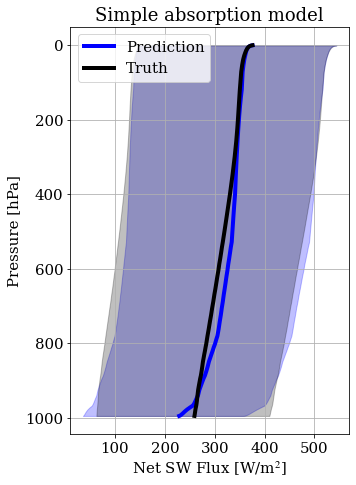

In [128]:
plt.figure(figsize=(5,7.5))

plt.plot(np.mean(F_pred,axis=0),pmean/100,color='b',label='Prediction')
plt.plot(np.mean(y,axis=0),pmean/100,color='k',label='Truth')

# plt.plot(np.percentile(a=F_pred,q=25,axis=0),pmean/100,color='b',linestyle='--')
# plt.plot(np.percentile(a=y,q=25,axis=0),pmean/100,color='k',linestyle='--')

# plt.plot(np.percentile(a=F_pred,q=75,axis=0),pmean/100,color='b',linestyle='--')
# plt.plot(np.percentile(a=y,q=75,axis=0),pmean/100,color='k',linestyle='--')

plt.fill_betweenx(y=pmean/100,
                  x1=np.percentile(a=F_pred,q=25,axis=0),
                  x2=np.percentile(a=F_pred,q=75,axis=0),
                  alpha=0.25,color='b')
plt.fill_betweenx(y=pmean/100,
                  x1=np.percentile(a=y,q=25,axis=0),
                  x2=np.percentile(a=y,q=75,axis=0),
                  alpha=0.25,color='k')

plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.xlabel('Net SW Flux [W/m$^{2}$]')
plt.ylabel('Pressure [hPa]')
plt.title('Simple absorption model')

In [129]:
np.mean((F_pred-y)**2)

909.53674

In [130]:
np.mean((y-np.mean(y,axis=0))**2)

69123.625

In [131]:
np.mean(y**2)

162273.44

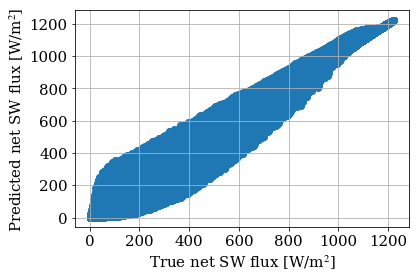

In [132]:
plt.scatter(y.flatten(),F_pred.flatten())
plt.xlabel('True net SW flux [W/m${^2}$]')
plt.ylabel('Predicted net SW flux [W/m${^2}$]')
plt.grid()

Predictions as a function of zenith angle

x = [Fnet_top,zenith_angle,p,qv,ql,qi] of length 294  
y = [Fnet] of length 72

In [133]:
# From https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- np ndarrays with the same shape.
    """
    if np.sum(weights)>0:
        average = np.average(values, weights=weights)
        variance = np.average((values-average)**2, weights=weights)
    else:
        average = np.nan
        variance = np.nan
    return (average, np.sqrt(variance))

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)

        edge_left = edge
    
    return Ym,Ystd

See if zenith angle used appropriately

In [134]:
his_za = np.histogram(x[:,1].flatten(),bins=100)

In [135]:
Y_av = conditional_avg_and_std(his_za[1],x[:,1],y[:,0])

In [136]:
Ypred_av = conditional_avg_and_std(his_za[1],x[:,1],F_pred[:,0])

In [137]:
# From edges to middle of bins
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

Text(0.5, 1.0, 'Conditional average')

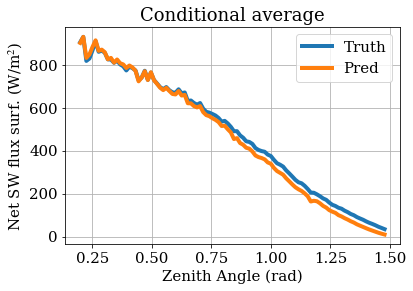

In [138]:
plt.plot(edgTObin(his_za[1]),Y_av[0],label='Truth')
plt.plot(edgTObin(his_za[1]),Ypred_av[0],label='Pred')
plt.grid()
plt.legend()
plt.xlabel('Zenith Angle (rad)')
plt.ylabel('Net SW flux surf. (W/m$^{2}$)')
plt.title('Conditional average')

Decomposing predictions

In [139]:
inp = K.Input(shape=(294,))
absorb = Absorb_Layer()([inp])
# optthi = Optical_Thickness()([inp,absorb])
# flux = Absorb_Flux()([inp,optthi])
model1 = tf.keras.models.Model(inp,absorb)

In [140]:
model1.compile(optimizer='Adam',loss='mse')

In [141]:
model1.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [142]:
model1.weights[0].assign(model.weights[0])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([0.00116458, 0.00286141, 0.00107097], dtype=float32)>

In [143]:
model1.weights[1].assign(model.weights[1])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.02102046], dtype=float32)>

In [144]:
model1.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([0.00116458, 0.00286141, 0.00107097], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.02102046], dtype=float32)>]

In [145]:
absorb_test = model1.predict(x)

In [146]:
absorb_test.shape

(898025, 73)

Text(0, 0.5, 'Pressure [Pa]')

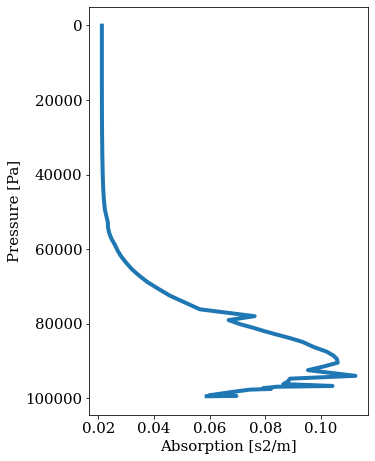

In [147]:
plt.figure(figsize=(5,7.5))

plt.plot(np.mean(absorb_test,axis=0),pmean)
plt.gca().invert_yaxis()
plt.xlabel('Absorption [s2/m]')
plt.ylabel('Pressure [Pa]')

In [148]:
inp = K.Input(shape=(294,))
absorb = Absorb_Layer()([inp])
optthi = Optical_Thickness()([inp,absorb])
# flux = Absorb_Flux()([inp,optthi])
model2 = tf.keras.models.Model(inp,optthi)

In [149]:
model2.compile(optimizer='Adam',loss='mse')

In [150]:
model2.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [151]:
model2.weights[0].assign(model.weights[0])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([0.00116458, 0.00286141, 0.00107097], dtype=float32)>

In [152]:
model2.weights[1].assign(model.weights[1])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.02102046], dtype=float32)>

In [154]:
# model2.weights[2].assign(model.weights[2])
# model2.weights[3].assign(model.weights[3])

In [155]:
model2.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([0.00116458, 0.00286141, 0.00107097], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.02102046], dtype=float32)>]

In [156]:
optT_test = model2.predict(x)

optT_test.shape

(898025, 73)

Text(0, 0.5, 'Pressure [Pa]')

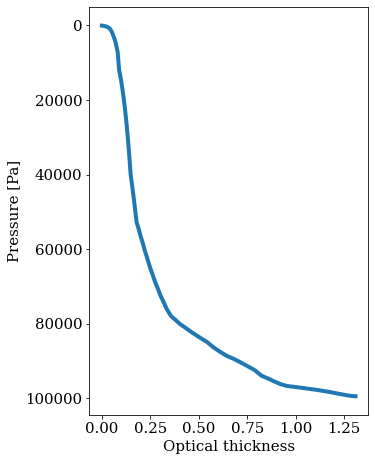

In [157]:
plt.figure(figsize=(5,7.5))

plt.plot(np.mean(optT_test,axis=0),pmean)
plt.gca().invert_yaxis()
plt.xlabel('Optical thickness')
plt.ylabel('Pressure [Pa]')